In [1]:
import os
import pickle

from tqdm import tqdm

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.io_utils as io_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
from matching.glema.common.dataset import BaseDataset

In [2]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "dpdf"
args.directed = False
args.anchored = True
args.iso = True
args.test_data = True

In [3]:
dataset_name = model_utils.get_dataset_name( args )
data_path = io_utils.get_abs_file_path( os.path.join( args.data_processed_dir, dataset_name ) )
data_path

'/Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/data/data_processed/dpdf'

In [4]:
key_file = os.path.join( data_path, args.test_keys if args.test_data else args.train_keys )
with open( key_file, "rb" ) as fp:
    keys = pickle.load( fp )
print( f"Number of total data points: {len( keys )}" )
iso_key_idxs = [ i for i, k in enumerate( keys ) if "iso" in k ]
non_iso_key_idxs = [ i for i, k in enumerate( keys ) if "non" in k ]
print( f"Data point split total: iso [{len( iso_key_idxs )}] / noniso [{len( non_iso_key_idxs )}]" )

Number of total data points: 478016
Data point split total: iso [240106] / noniso [237910]


In [5]:
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}


def get_sample( dataset, sample_idx, relabel=True, normalize_d=-1 ):
    sample_data = dataset.get_data( sample_idx )
    query, source, mapping = sample_data
    mapping = { qnid: snid for qnid, snid in mapping }
    if relabel:
        query = graph_utils.relabel_nodes( query, mapping )
    if normalize_d > 0:
        source, _ = graph_utils.normalize_graph( source, max_distance=6, force_directed=True )
        query, _ = graph_utils.normalize_graph( query, max_distance=6, force_directed=True )
    return source, query, mapping


def is_iso( dataset, sample_idx ):
    return "iso" in dataset.get_key( sample_idx )


def get_colors( G ):
    return [ "purple" if d[ "anchor" ] == 1 else "grey" for n, d in G.nodes( data=True ) ]

In [6]:
complexity_keys = model_utils.load_complexity_keys( args, train=not args.test_data )
for (key, values) in complexity_keys.items():
    print( f"complexity {key}: {len( values )} samples" )

complexity 1: 0 samples
complexity 2: 62144 samples
complexity 3: 81024 samples
complexity 4: 73664 samples
complexity 5: 132288 samples
complexity 6: 111424 samples


In [7]:
dataset = BaseDataset( keys, args,
                       k_start=1, k_keys=complexity_keys,
                       max_size=10_000 )
print( f"Current complexity: {dataset.get_complexity_limit()}" )
dataset.remove_complexity_limit()

iso_key_idxs = [ idx for idx in list( range( dataset.__len__() ) ) if is_iso( dataset, idx ) ]
non_iso_key_idxs = [ idx for idx in list( range( dataset.__len__() ) ) if not is_iso( dataset, idx ) ]
print( f"Number of data points: {dataset.__len__()}" )
print( f"Data point split: iso [{len( iso_key_idxs )}] / noniso [{len( non_iso_key_idxs )}]" )

iso_keys, non_iso_keys = dataset.get_key_split()
print( f"actual data points: iso [{len( iso_keys )}] / noniso [{len( non_iso_keys )}]" )

Current complexity: 2
Removed graph sample complexity limit
Number of data points: 10000
Data point split: iso [5000] / noniso [5000]
actual data points: iso [5000] / noniso [5000]


{'H': array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

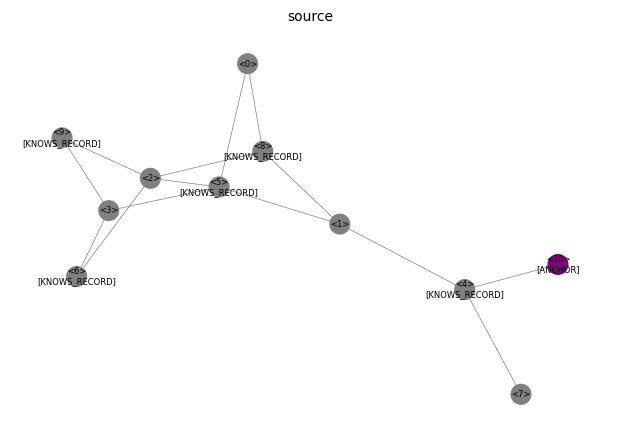

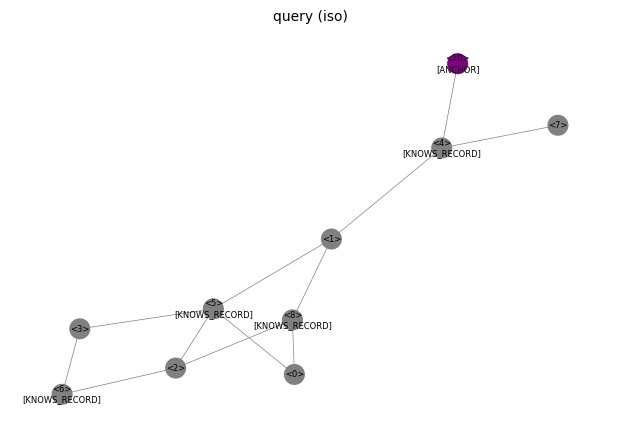

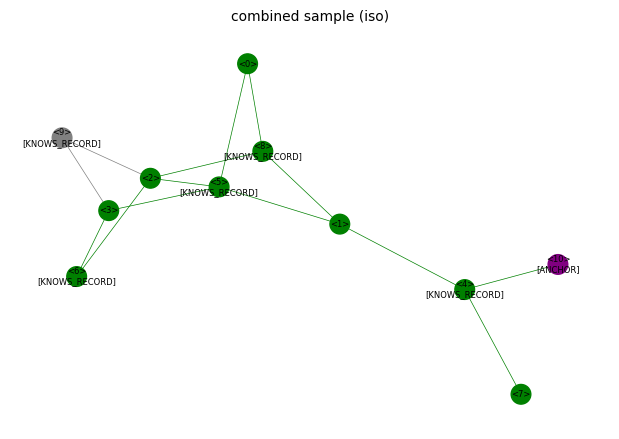

In [8]:
sample_idx = iso_key_idxs[ 0 ]
source, query, _ = get_sample( dataset, sample_idx )
print( dataset.__getitem__( sample_idx ) )

combined, n_colors, e_colors = graph_utils.combine_graph( source, query, matching_colors=matching_colors )
#combined, n_colors, e_colors = graph_utils.combine_normalized( source, query, matching_colors=matching_colors )

plot_utils.plot_graph( title="source", graph=source,
                       nodeColors=get_colors( source ),
                       nodeLabels=graph_utils.get_node_labels( source ) )
plot_utils.plot_graph( title="query (iso)", graph=query,
                       nodeColors=get_colors( query ),
                       nodeLabels=graph_utils.get_node_labels( query ) )
plot_utils.plot_graph(
    title="combined sample (iso)", graph=combined,
    nodeColors=n_colors, edgeColors=e_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)

{'H': array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'A1': array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]]), 'A2': array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]]), 'Y': 0, 'V': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'key': '5192_15_non_test', 'mapp

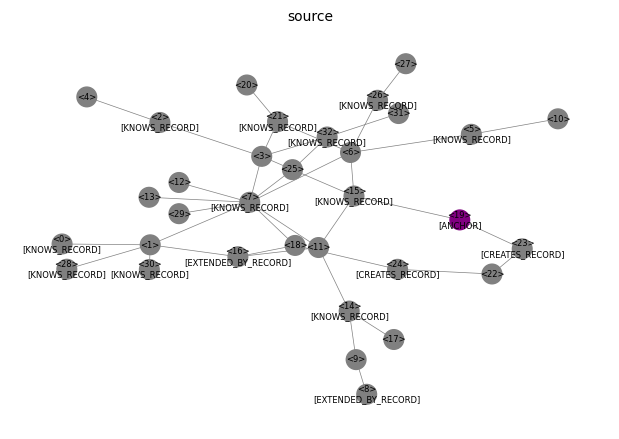

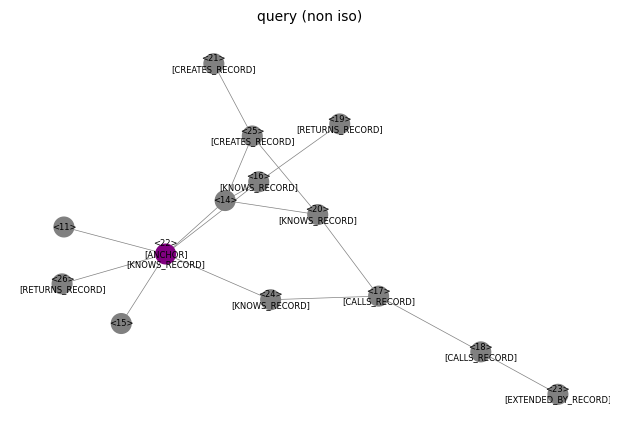

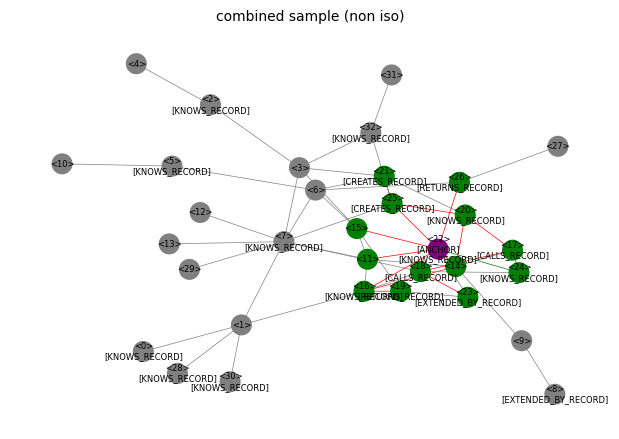

In [9]:
sample_idx = non_iso_key_idxs[ 4 ]
source, query, _ = get_sample( dataset, sample_idx )
print( dataset.__getitem__( sample_idx ) )

combined, n_colors, e_colors = graph_utils.combine_graph( source, query, matching_colors=matching_colors )
#combined, n_colors, e_colors = graph_utils.combine_normalized( source, query, matching_colors=matching_colors )

plot_utils.plot_graph( title="source", graph=source,
                       nodeColors=get_colors( source ),
                       nodeLabels=graph_utils.get_node_labels( source ) )
plot_utils.plot_graph( title="query (non iso)", graph=query,
                       nodeColors=get_colors( query ),
                       nodeLabels=graph_utils.get_node_labels( query ) )
plot_utils.plot_graph(
    title="combined sample (non iso)", graph=combined,
    nodeColors=n_colors, edgeColors=e_colors,
    nodeLabels=graph_utils.get_node_labels( combined )
)

In [10]:
sources_with_anchor = 0
queries_with_anchor = 0
iso_samples = 0
non_iso_samples = 0
iso_samples_with_same_anchor = 0
non_iso_samples_with_same_anchor = 0
iso_samples_with_bigger_query = 0
non_iso_samples_with_bigger_query = 0

sources_max_5 = 0
sources_5_10 = 0
sources_10_15 = 0
sources_15_20 = 0
sources_20_30 = 0
sources_30_40 = 0
sources_min_40 = 0

queries_max_5 = 0
queries_5_10 = 0
queries_10_15 = 0
queries_15_20 = 0
queries_20_30 = 0
queries_30_40 = 0
queries_min_40 = 0

iso_samples_are_iso = 0
non_iso_samples_are_iso = 0
measure_iso = False

dataset_len = dataset.__len__()
for sample_idx in tqdm( list( range( dataset_len ) ) ):

    is_iso_sample = False
    if is_iso( dataset, sample_idx ):
        is_iso_sample = True
        iso_samples += 1
    else:
        non_iso_samples += 1

    source, query, mapping = get_sample( dataset, sample_idx, relabel=True )

    source_anchor = graph_utils.get_anchor( source )
    if source_anchor >= 0:
        sources_with_anchor += 1

    query_anchor = graph_utils.get_anchor( query )
    if query_anchor >= 0:
        queries_with_anchor += 1

        if source_anchor == query_anchor:
            if is_iso_sample:
                iso_samples_with_same_anchor += 1
            else:
                non_iso_samples_with_same_anchor += 1

    if query.number_of_nodes() > source.number_of_nodes():
        if is_iso_sample:
            iso_samples_with_bigger_query += 1
        else:
            non_iso_samples_with_bigger_query += 1

    source_size = source.number_of_nodes()
    if source_size <= 5:
        sources_max_5 += 1
    if 5 < source_size <= 10:
        sources_5_10 += 1
    if 10 < source_size <= 15:
        sources_10_15 += 1
    if 15 < source_size <= 20:
        sources_15_20 += 1
    if 20 < source_size <= 30:
        sources_20_30 += 1
    if 30 < source_size <= 40:
        sources_30_40 += 1
    if 40 < source_size:
        sources_min_40 += 1

    query_size = query.number_of_nodes()
    if query_size <= 5:
        queries_max_5 += 1
    if 5 < query_size <= 10:
        queries_5_10 += 1
    if 10 < query_size <= 15:
        queries_10_15 += 1
    if 15 < query_size <= 20:
        queries_15_20 += 1
    if 20 < query_size <= 30:
        queries_20_30 += 1
    if 30 < query_size <= 40:
        queries_30_40 += 1
    if 40 < query_size:
        queries_min_40 += 1

    if measure_iso:
        if graph_utils.is_iso_subgraph( source, query ):
            if is_iso_sample:
                iso_samples_are_iso += 1
            else:
                non_iso_samples_are_iso += 1

print( f"Sources with anchor: {sources_with_anchor}/{dataset_len}" )
print( f"Queries with anchor: {queries_with_anchor}/{dataset_len}" )
print( f"Iso samples with same anchor: {iso_samples_with_same_anchor}/{iso_samples}" )
print( f"Non iso samples with same anchor: {non_iso_samples_with_same_anchor}/{non_iso_samples}" )
print( f"Iso samples with bigger query: {iso_samples_with_bigger_query}/{iso_samples}" )
print( f"Non iso samples with bigger query: {non_iso_samples_with_bigger_query}/{non_iso_samples}" )

print( f"Source samples with nodes size smaller 5: {sources_max_5}" )
print( f"Source samples with nodes size between 5-10: {sources_5_10}" )
print( f"Source samples with nodes size between 10-15: {sources_10_15}" )
print( f"Source samples with nodes size between 15-20: {sources_15_20}" )
print( f"Source samples with nodes size between 20-30: {sources_20_30}" )
print( f"Source samples with nodes size between 30-40: {sources_30_40}" )
print( f"Source samples with nodes size greater 40: {sources_min_40}" )

print( f"Queries samples with nodes size smaller 5: {queries_max_5}" )
print( f"Queries samples with nodes size between 5-10: {queries_5_10}" )
print( f"Queries samples with nodes size between 10-15: {queries_10_15}" )
print( f"Queries samples with nodes size between 15-20: {queries_15_20}" )
print( f"Queries samples with nodes size between 20-30: {queries_20_30}" )
print( f"Queries samples with nodes size between 30-40: {queries_30_40}" )
print( f"Queries samples with nodes size greater 40: {queries_min_40}" )

if measure_iso:
    print( f"Iso samples are iso: {iso_samples_are_iso}/{iso_samples}" )
    print( f"Non iso samples are iso: {non_iso_samples_are_iso}/{non_iso_samples}" )

100%|██████████| 10000/10000 [00:04<00:00, 2110.44it/s]

Sources with anchor: 10000/10000
Queries with anchor: 10000/10000
Iso samples with same anchor: 5000/5000
Non iso samples with same anchor: 762/5000
Iso samples with bigger query: 0/5000
Non iso samples with bigger query: 0/5000
Source samples with nodes size smaller 5: 0
Source samples with nodes size between 5-10: 1297
Source samples with nodes size between 10-15: 1719
Source samples with nodes size between 15-20: 1621
Source samples with nodes size between 20-30: 2647
Source samples with nodes size between 30-40: 2321
Source samples with nodes size greater 40: 395
Queries samples with nodes size smaller 5: 2050
Queries samples with nodes size between 5-10: 2647
Queries samples with nodes size between 10-15: 1871
Queries samples with nodes size between 15-20: 1282
Queries samples with nodes size between 20-30: 1556
Queries samples with nodes size between 30-40: 579
Queries samples with nodes size greater 40: 15
